# Analyzing and comparing the radius of gyration and hydrodynamicradius in conformational ensembles of intrinsically disordered proteins
In this example we will be showing the procedure to calculate Rg and Rh as described in the paper "Analyzing and comparing the radius of gyration and hydrodynamicradius in conformational ensembles of intrinsically disordered proteins"

Step by step we will show:
    1. Calculate Rg and Rh from file or a trajectoty using MDtraj
    2. Show how the input data should be structured for the BME software
    3. Perform reweighing procudre with BME and Select the parameter $\theta$
    4. Plot figures

##Note! 
You should have installed the python modules: BME, Numpy, seaborn, scipy, and MDtraj beforehand
and lso made sure you set the correct path to the BME module
more information on the BME code can be obtained at https://github.com/KULL-Centre/BME
Furthermore, we will not provide detail instructions for how to: 
generate conformational ensembles
calculate ensemble values 
reader is expected to have done this beforehand.

In [1]:
### import modules 
import sys
import os
directory_to_bme = os.getcwd()[:-8]
sys.path.append(directory_to_bme)     ### set the path to BME directory here
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import bme_reweight as bme
from pylab import genfromtxt;
import mdtraj as md

# 1 Calculating Rg and Rh
Now that we have loaded all the required modules, 
We can load a trajetory in MDtraj and calculate the Rg for each frame.
Equation 3 in the main text converts Rg values to Rh and is parameterized using C-alpha atoms and parameters er in Angstiom. So we select the c-alpha
The Ensemble we load consist of 10.000 frames sampled with Campari. 

In [2]:
###  MDtraj loading trajectory and calculating Rg  
traj = md.load("Ensemble.trr",top="structure.pdb") # load trajectory and structure file
                
CA_atoms = traj.topology.select('name CA')    # selecting C-alpha atoms 
traj.atom_slice(CA_atoms, inplace=True)

rg = md.compute_rg(traj)                         # Converting Rg from nm to Angstrom

Rg = np.reshape(np.array(rg*10),[-1, 1])
print Rg
np.savetxt('Rg_calc.dat', np.c_[Rg]) # saves Rg values to the file "Rg_calc.dat"



[[ 26.05150339]
 [ 27.39512119]
 [ 22.13320178]
 ..., 
 [ 16.81065577]
 [ 16.88125215]
 [ 17.07489347]]


We can also load Rg values from a file:

In [3]:
### load Rg values from file
Rg = np.array([float(line.split()[0]) for line in open("Rg_calc.dat")])
print Rg

[ 26.05150339  27.39512119  22.13320178 ...,  16.81065577  16.88125215
  17.07489347]


We now calculate Rh for each frame, using equation 3 from Nygaard et al.
and print the ensemble average Rg and Rh of the trajectory

In [15]:

### Rh calculation
a1 =0.216 
a2 =4.06
a3 =0.921
N =traj.n_residues   

def getRh(R,N):
    return ((a1*(R-a2*N**(0.33)))/(N**(0.6)-N**(.33))+a3)/(R) # function calculates 1/Rh using Rg of each frame
    
Rh =1/getRh(Rg,N)  


# Print the ensemble average Rg and Rh
print 'Initial <Rg>:',np.mean(Rg), '    Initial <Rh>:',np.mean(Rh) 

Initial <Rg>: 19.4122603985     Initial <Rh>: 20.223626332


In [16]:
### experimental Rg and Rh and error values
RgExp =29.5
RgExpe =1.5
RhExp =21.5
RhExpe =1.1



# 2 Input data and how it is structured
In this example we will only be showing the input file for SAXS data and Rh 
BME takes two input files for the reweighting: 
(I) A experimental file 
(II) A file with calculated values of the same experimental observable 

We start by first looking at the format of the experimental file :

In [17]:
# Experimental SAXS input file
%cat saxs_exp.dat 
saxs = 'saxs_exp.dat'





# DATA=SAXS PRIOR=GAUSS
0.023303 0.00087271 0.00004730
0.024413 0.00086838 0.00003923
0.025522 0.00084326 0.00004237
0.026632 0.00082876 0.00003437
0.027742 0.00081364 0.00002729
0.028851 0.00080704 0.00003766
0.029961 0.00079905 0.00003528
0.031071 0.00077278 0.00003294
0.032180 0.00075426 0.00003089
0.033290 0.00073401 0.00003041
0.034400 0.00072652 0.00002610
0.035509 0.00071407 0.00002938
0.036619 0.00069929 0.00002536
0.037729 0.00068648 0.00003313
0.038838 0.00066639 0.00002809
0.039948 0.00066899 0.00002364
0.041058 0.00063673 0.00002483
0.042167 0.00061890 0.00002378
0.043277 0.00061224 0.00002266
0.044387 0.00060969 0.00002316
0.045496 0.00058985 0.00002321
0.046606 0.00057709 0.00002219
0.047716 0.00056726 0.00002077
0.048825 0.00055049 0.00001914
0.049935 0.00053576 0.00002552
0.051045 0.00052398 0.00001983
0.052154 0.00051061 0.00002260
0.053264 0.00050433 0.00002037
0.054374 0.00049545 0.00002091
0.055483 0.00049139 0.00002216
0.056593 0.00047667 0.00001929
0.057703 0.0004

The first line in the file is a header that defines the type of data and the error model it should use. Currently(May 2019) it only have Gaussain error model implemented. However BME can be used with several other type of data (e.q NOE, CS, RC) 

In column 1, 2 and 3 we have the experimental value of the: scatter vector, intensity and error, respectively. The number of the rows is equil to how many data points you have. In this case 179.  

Note: The unit is not relevant as long as they are all consistent in the experimental and calculated data file.


The corresponding calculated data file(saxs_calc.dat)look like this(only showing the first two rows for the pupose of saving screen space):

In [18]:
# Calculates  SAXS input
%cat saxs_calc.dat| head -2

frame_0.pdb 0.00084394 0.00083215 0.00082037 0.00080857 0.00079674 0.00078489 0.00077299 0.00076105 0.00074906 0.00073700 0.00072487 0.00071267 0.00070037 0.00068798 0.00067551 0.00066292 0.00065026 0.00063756 0.00062483 0.00061209 0.00059940 0.00058674 0.00057416 0.00056170 0.00054935 0.00053715 0.00052513 0.00051331 0.00050171 0.00049036 0.00047924 0.00046836 0.00045773 0.00044734 0.00043720 0.00042731 0.00041766 0.00040827 0.00039913 0.00039025 0.00038163 0.00037326 0.00036516 0.00035732 0.00034972 0.00034238 0.00033528 0.00032842 0.00032179 0.00031539 0.00030922 0.00030327 0.00029753 0.00029200 0.00028668 0.00028157 0.00027664 0.00027191 0.00026736 0.00026298 0.00025877 0.00025471 0.00025081 0.00024705 0.00024342 0.00023992 0.00023655 0.00023328 0.00023012 0.00022706 0.00022409 0.00022121 0.00021841 0.00021568 0.00021303 0.00021045 0.00020794 0.00020548 0.00020308 0.00020074 0.00019844 0.00019618 0.00019396 0.00019177 0.00018961 0.00018748 0.00018539 0.00018332 0.00018128 0.0001792

saxs_calc.dat has 180 columns. The first being a label(eq. frame_1.pdb), and then one column per experimental average, we have in total 179. The number of rows depends on how many structures/frames you have in the ensemble. In this case, we have 10.000 frames.

# 3 BME reweighting and  θ selection
We here show how to apply the BME reweighting procedure. Essentially, there are only three fundamental steps:

1. Initialize the class
2. Load the data
3. Optimize


We start by showing how to Initialize the BME and load the data. Then, to find a viable value for the θ parameter,  We scan different values of θ and plot $\chi^2_{re}$ and the total $\chi^2$ versus the fraction of effective frames ($N_{eff} = exp(S_{rel})$).:

In [19]:
###### BME reweighting 


### define name and read experimental and calculated data.                                                                        
exp_saxs = 'saxs_exp.dat'
calc_saxs = 'saxs_calc.dat'
exp_rh = 'rh_exp.dat'
calc_rh = 'rh_calc.dat'

### initialize reweighting class                                                                                                                                
rew = bme.Reweight()

### load SAXS data                                                                                      
rew.load(exp_saxs,calc_saxs)

### load Rh data                                                                                      
rew.load(exp_rh,calc_rh)


### do minimization for different values of theta
thetas= [0.7,1,2,5,10,20,50,70,100,150,200,300,500,5000]
results = []
for t in thetas:
    # do the minimization
    chi2_all_before,chi2_all_after, srel = rew.optimize(theta=t)
    
    # calculate agreement with SAXS and Rh, and write output to a temporary file
    chi2_rh_before,chi2_rh_after = rew.weight_exp(exp_rh,calc_rh,"tmp")
    chi2_saxs_before,chi2_saxs_after = rew.weight_exp(exp_saxs,calc_saxs,"tmp1")
    results.append( [np.exp(srel),chi2_all_before,chi2_all_after,chi2_rh_before,chi2_rh_after,chi2_saxs_before,chi2_saxs_after])
    

# exp data: (180, 2)
# calc data: (32000, 180)
# exp data: (180, 2)
# calc data: (32000, 180)
# exp data: (180, 2)
# calc data: (32000, 180)
# exp data: (180, 2)
# calc data: (32000, 180)
# exp data: (180, 2)
# calc data: (32000, 180)
# exp data: (180, 2)
# calc data: (32000, 180)
# exp data: (180, 2)
# calc data: (32000, 180)
# exp data: (180, 2)
# calc data: (32000, 180)
# exp data: (180, 2)
# calc data: (32000, 180)
# exp data: (180, 2)
# calc data: (32000, 180)
# exp data: (180, 2)
# calc data: (32000, 180)
# exp data: (180, 2)
# calc data: (32000, 180)
# exp data: (180, 2)
# calc data: (32000, 180)
# exp data: (180, 2)
# calc data: (32000, 180)


# 4 Figures
we now plot figure 2.a in the main text

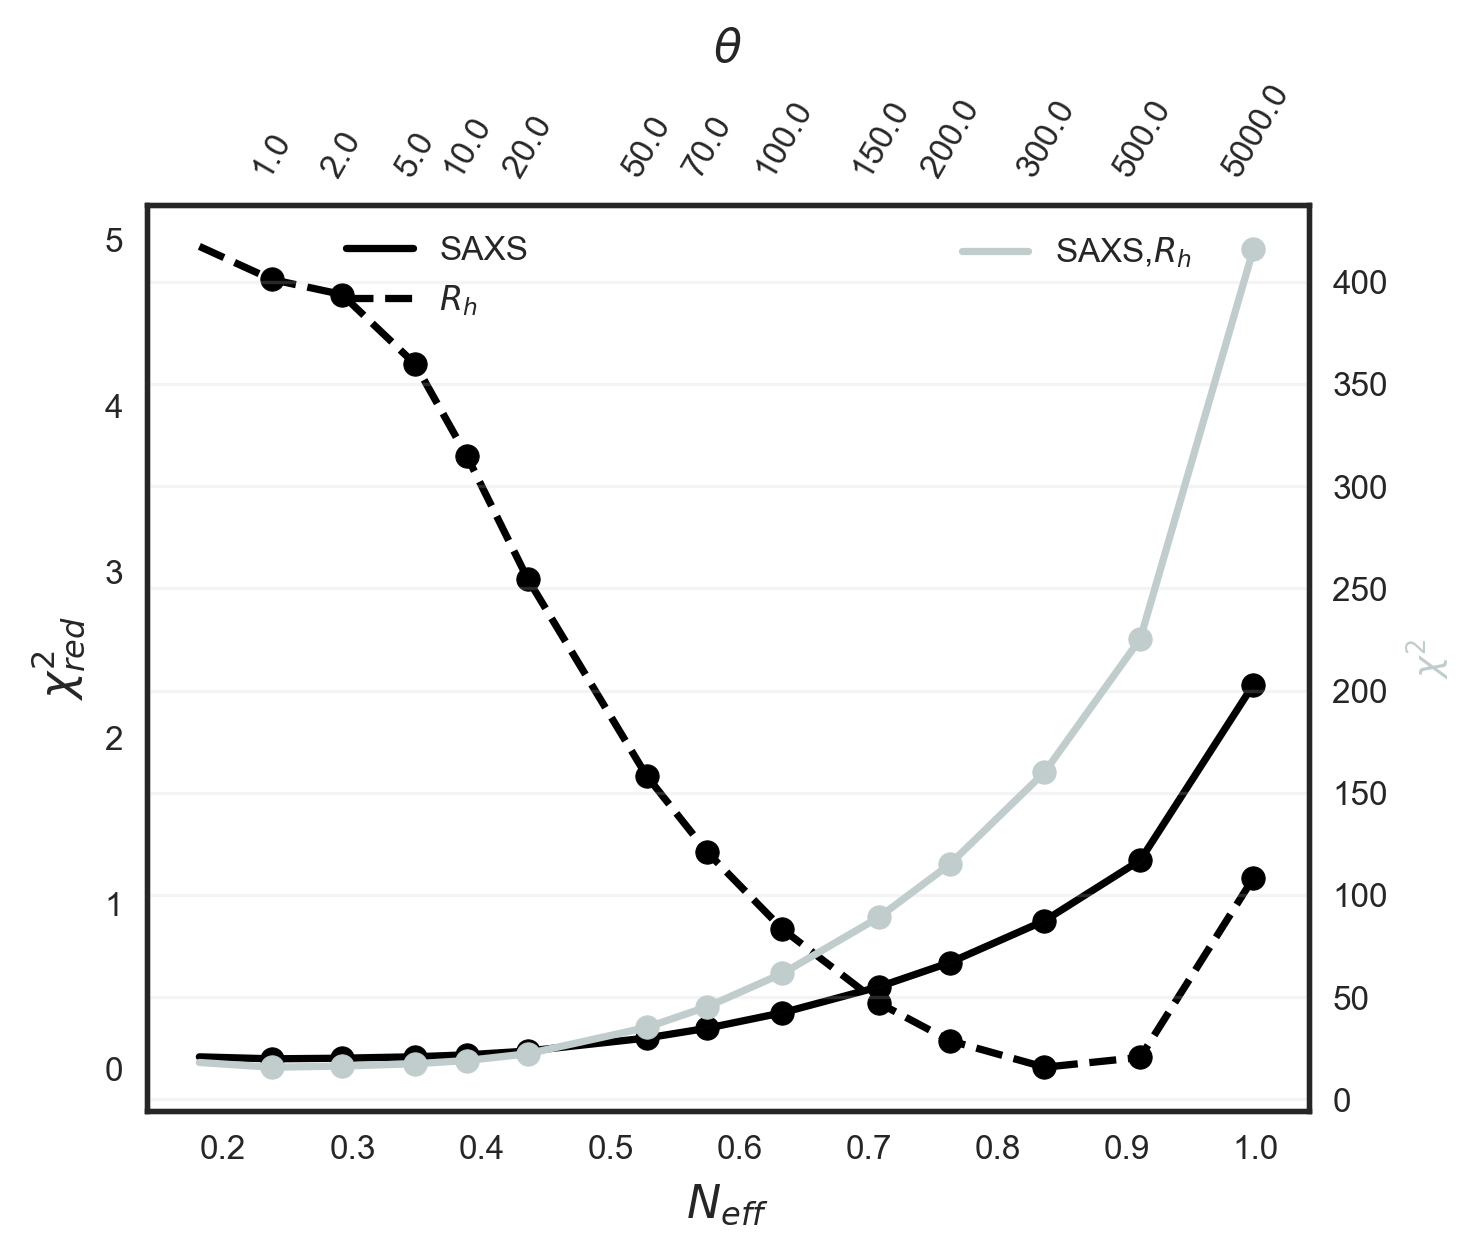

In [20]:
### Plot figure for different values of theta vs Neff and chi^2
sns.set_style("white")
sns.set_context("paper")

# handling tickers and read data
from matplotlib.ticker import NullFormatter
from matplotlib import ticker
import matplotlib as mpl
mpl.rcParams['figure.dpi'] =300
results = np.array(results)



# define the figure
fig, ax1 = plt.subplots(figsize=(5, 4))

# plot SAXS and Rh
ax1.plot(results[:,0],results[:,6],label="SAXS",c='k',ls="-",lw=1.75)
ax1.plot(results[:,0],results[:,4],label="$R_h$",c='k',ls="--",lw=1.75)



# set tickers
ax1.set_xticks([0,0.1,0.2,0.3,0.4,0.5,.6,0.7,0.8,0.9,1.0])
ax1.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax1.xaxis.set_major_formatter(ticker.FormatStrFormatter("%3.1f"))
ax1.xaxis.set_minor_formatter(ticker.NullFormatter())

# Make a new horizontal axis to show the theta values and a new vertical axis to show the chi^2 total
ax2 = ax1.twiny()
ax2.plot(results[:,0],results[:,2],c='grey',lw=0.01)
ax3 = ax1.twinx()
ax3.plot(results[:,0],results[:,2]*180,label="SAXS,$R_h$",c='#C1CDCD',lw=1.75)

#draw ticks at selected theta
sele = [1,2,5,10,20,50,70,100,150,200,300,500,5000]
iis = [thetas.index(s) for s in  sele]
ax2.set_xticks(results[iis,0])
ax2.set_xticklabels(["%.1f"% s for s in sele],rotation=60)
ax1.scatter(results[iis,0],results[iis,4],c='k')
ax1.scatter(results[iis,0],results[iis,6],c='k')

ax3.scatter(results[iis,0],results[iis,2]*180,c='#C1CDCD')
ax3.set_ylabel(r"$\chi^2$", color='#C1CDCD')
ax1.set_xlabel("$N_{eff}$",fontsize=11)
ax2.set_xlabel(r"$\theta$",fontsize=11)
ax1.set_ylabel(r"$\chi^2_{red}$",fontsize=11)
plt.grid(alpha=0.2)
ax1.legend(loc='upper center',bbox_to_anchor=(0.25, 0.5, 0.0, 0.5))
ax3.legend(loc='upper center',bbox_to_anchor=(0.5, 0.5, 0.6, 0.5))
plt.show()

Based on the plot above, one would choose a $\theta=50$ or $\theta=150$, as there is a clear minimum around this value for the SAXS,Rh $\chi^2$. In our example we have used $\theta=70$. We can look how  $\chi^{2}_{re}$ lower after the reweighting:

In [21]:
# select theta=70 
chi2_before,chi2_after, srel = rew.optimize(theta=70)

print "# CHI2_re before minimization:     %8.4f" % (chi2_before)
print "# CHI2_re after minimization:      %8.4f" % (chi2_after)
print "# Fraction of effective frames: %8.4f" % (np.exp(srel))


# exp data: (180, 2)
# calc data: (32000, 180)
# CHI2_re before minimization:       2.5000
# CHI2_re after minimization:        0.2519
# Fraction of effective frames:   0.5751


The $\chi^2_{re}$ drops from 2.5000 to 0.2519 after rewighting with $\theta=70$. 
Now that we have new weights it is very easy to calculate any average/distribution of interest.
We now plot the distribution Rg and Rh after and before reweighting using $\theta=70$. 
but first start by block averaging the data:


In [22]:
##### Block averaging and plot figure   

### Set bins for block average and optimal theta to use
n_frames = len(Rg)
n_bins =5
bin_size = n_frames/n_bins
bins = range(0,n_frames+bin_size,bin_size)
theta=50


### split in 5 blocks
for j in range(len(bins)-1):

    rows = range(bins[j],bins[j+1])
    rew = bme.Reweight()
    rew.load(exp_saxs,calc_saxs,rows=rows)
    rew.load(exp_rh,calc_rh,rows=rows)
    rew.optimize(theta=theta)

    
    rew.weight_exp(exp_saxs,calc_saxs, 'example2_%d_' % (j),rows=rows)

    w_opt = rew.get_weights()

    ### write weights to file
    w0 = [1./len(w_opt)]*len(w_opt)
    string = np.array("".join([ "%10.4e %10.4e \n " % (w0[k],w_opt[k])for k in range(len(w_opt))]))
    fh = open("example2_%d_weights.dat" % j,"w")
    fh.write(string)
    fh.close()


 

# exp data: (180, 2)
# calc data: (6400, 180)
# exp data: (180, 2)
# calc data: (6400, 180)
# exp data: (180, 2)
# calc data: (6400, 180)
# exp data: (180, 2)
# calc data: (6400, 180)
# exp data: (180, 2)
# calc data: (6400, 180)


We now plot the Rg and Rh distrubutions. 

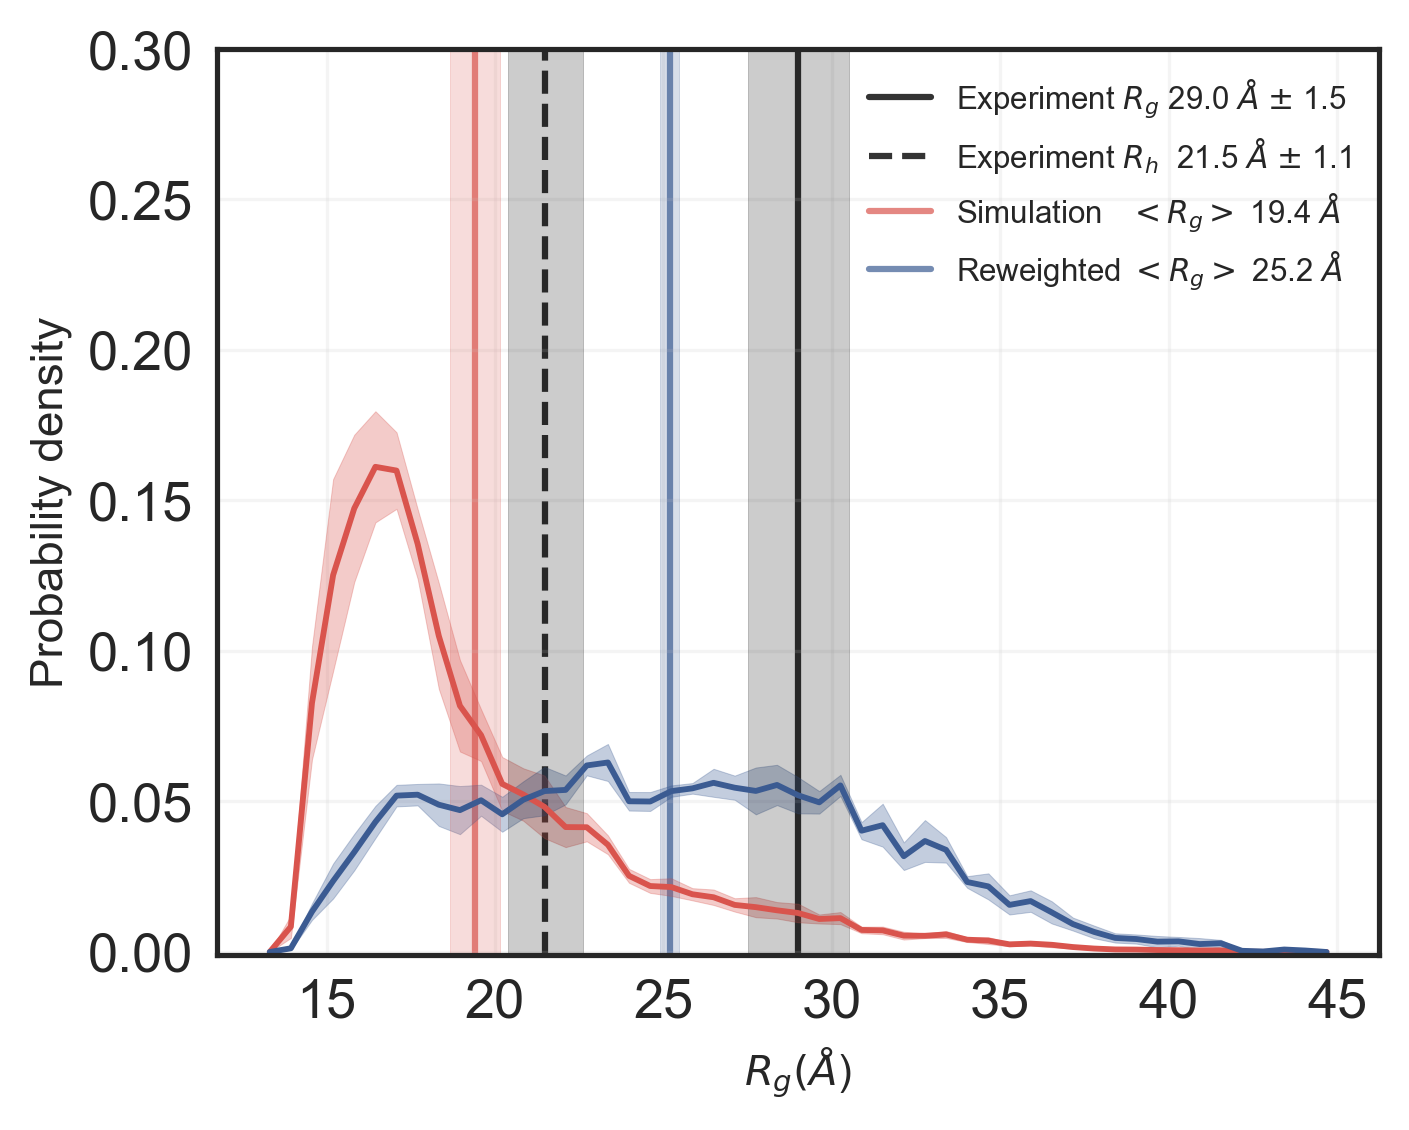

In [23]:
data=  Rg


sns.set_style("white")
sns.set_context("paper")
mpl.rcParams['figure.dpi'] =300


fig,ax = plt.subplots(1,1,figsize=(5,4))
ax.set_ylabel("Probability density",fontsize=11)
ax.set_xlabel("$R_g (\AA$)",fontsize=10)
ax.tick_params(axis='both', labelsize=13)

c1 = sns.xkcd_rgb["black"]
c2 = sns.xkcd_rgb["pale red"]
c3 = sns.xkcd_rgb["denim blue"]
hist_0 = []
hist_post = []
binsize = n_frames/n_bins
sqrt_nbins = 1./np.sqrt(n_bins)
meanRga=[]
meanRgb=[]
bins = np.linspace(13,45,52)

for j in range(n_bins):
    # read weights

    weights = np.array([float(line.split()[1]) for line in open("example2_%d_weights.dat" % j)
                        if (("#" not in line) and (len(line.split())==2))])
    Rgb = np.mean(data[j*binsize:(j+1)*binsize])
    Rga =np.sum(weights*data[j*binsize:(j+1)*binsize])
    meanRgb.append(Rgb)
    meanRga.append(Rga)
    
    hh_0, ee_0 = np.histogram(data[j*binsize:(j+1)*binsize],density=True,bins=bins)
    hist_0.append(hh_0)
    hh_post, ee_1 = np.histogram(data[j*binsize:(j+1)*binsize],density=True,bins=bins,weights=weights)
  
    
    hist_post.append(hh_post)
xx = 0.5*(ee_0[1:]+ee_0[:-1])

avg_0 = np.average(hist_0,axis=0)
sem_0 = sqrt_nbins*np.std(hist_0,axis=0,ddof=1)
ax.plot(xx,avg_0,color=c2,ls='-')
ax.fill_between(xx,avg_0-sem_0,avg_0+sem_0,color=c2,alpha=0.3)
avg_post = np.average(hist_post,axis=0)
sem_post = sqrt_nbins*np.std(hist_post,axis=0,ddof=1)
ax.plot(xx,avg_post,color=c3,ls='-')

ax.fill_between(xx,avg_post-sem_post,avg_post+sem_post,color=c3,alpha=0.3)

ax.axvspan(29-1.5,29+1.5, alpha=0.2, color=c1)
ax.axvspan(21.5-1.1,21.5+1.1, alpha=0.2, color=c1)
plt.axvline(29,ls='-',color=c1,alpha=0.8,lw=1.5,zorder=0,label='Experiment $R_g$ 29.0 $\AA$ $\pm$ 1.5' )
plt.axvline(21.5,ls='--',color=c1,alpha=0.8,lw=1.5,zorder=0,label='Experiment $R_h$  21.5 $\AA$ $\pm$ 1.1' )
ax.axvspan(np.mean(meanRgb)-np.std(meanRgb),np.mean(meanRgb)+np.std(meanRgb), alpha=0.2, color=c2)
ax.axvspan(np.mean(meanRga)-np.std(meanRga),np.mean(meanRga)+np.std(meanRga), alpha=0.2, color=c3)

plt.axvline(np.round(np.mean(meanRgb),decimals=2),ls='-',c=c2,alpha=0.7,lw=1.5,zorder=0,label='Simulation   $<R_g>$ ' + 
             np.str(np.round(np.mean(meanRgb),decimals=1))+ ' $\AA$')
plt.axvline(np.round(np.mean(meanRga),decimals=2),ls='-',color=c3,alpha=0.7,lw=1.5,zorder=0,label='Reweighted $<R_g>$ '+ 
             np.str(np.round(np.mean(meanRga),decimals=1))+ ' $\AA$')

plt.ylim(-0.001,0.3)
plt.grid(alpha=0.2)
plt.legend( prop={'size': 7.5})
plt.show()

#plt.savefig('rg_plot.png')





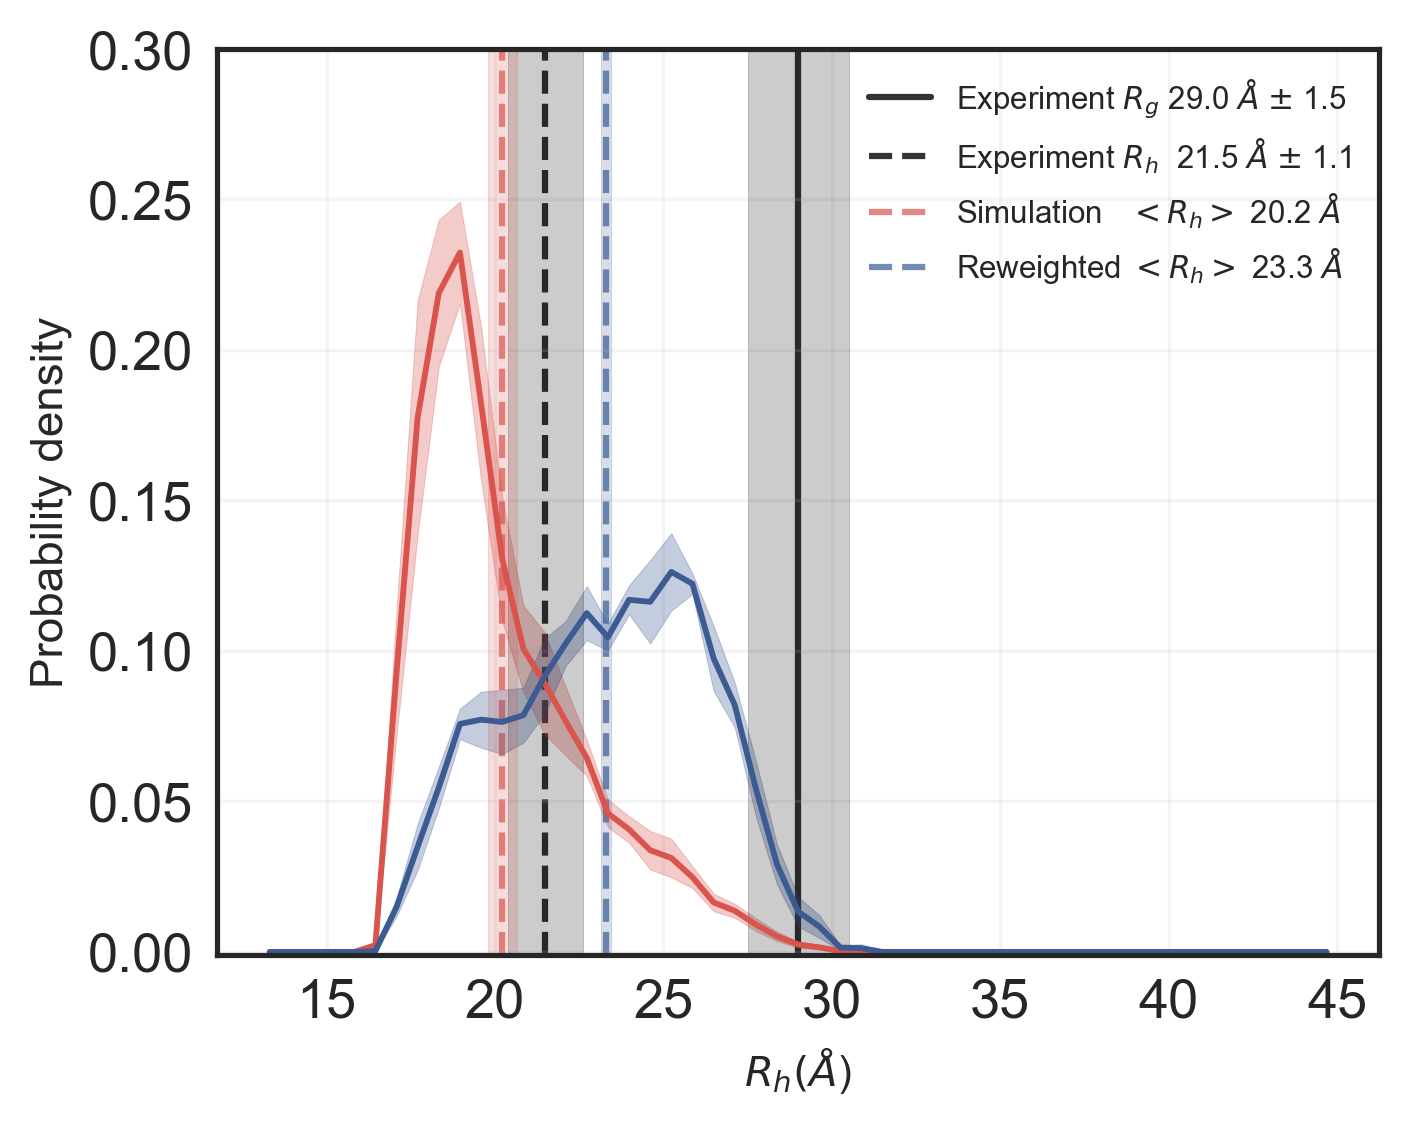

In [24]:
data=  Rh

sns.set_style("white")
sns.set_context("paper")
mpl.rcParams['figure.dpi'] =300


fig,ax = plt.subplots(1,1,figsize=(5,4))
ax.set_ylabel("Probability density",fontsize=11)
ax.set_xlabel("$R_h (\AA$)",fontsize=10)
ax.tick_params(axis='both', labelsize=13)

c1 = sns.xkcd_rgb["black"]
c2 = sns.xkcd_rgb["pale red"]
c3 = sns.xkcd_rgb["denim blue"]
hist_0 = []
hist_post = []
binsize = n_frames/n_bins
sqrt_nbins = 1./np.sqrt(n_bins)
meanRga=[]
meanRgb=[]
bins = np.linspace(13,45,52)

for j in range(n_bins):
    # read weights

    weights = np.array([float(line.split()[1]) for line in open("example2_%d_weights.dat" % j)
                        if (("#" not in line) and (len(line.split())==2))])
    Rgb = np.mean(data[j*binsize:(j+1)*binsize])
    Rga =np.sum(weights*data[j*binsize:(j+1)*binsize])
    meanRgb.append(Rgb)
    meanRga.append(Rga)
    
    hh_0, ee_0 = np.histogram(data[j*binsize:(j+1)*binsize],density=True,bins=bins)
    hist_0.append(hh_0)
    hh_post, ee_1 = np.histogram(data[j*binsize:(j+1)*binsize],density=True,bins=bins,weights=weights)
  
    
    hist_post.append(hh_post)
xx = 0.5*(ee_0[1:]+ee_0[:-1])

avg_0 = np.average(hist_0,axis=0)
sem_0 = sqrt_nbins*np.std(hist_0,axis=0,ddof=1)
ax.plot(xx,avg_0,color=c2,ls='-')
ax.fill_between(xx,avg_0-sem_0,avg_0+sem_0,color=c2,alpha=0.3)
avg_post = np.average(hist_post,axis=0)
sem_post = sqrt_nbins*np.std(hist_post,axis=0,ddof=1)
ax.plot(xx,avg_post,color=c3,ls='-')

ax.fill_between(xx,avg_post-sem_post,avg_post+sem_post,color=c3,alpha=0.3)

ax.axvspan(29-1.5,29+1.5, alpha=0.2, color=c1)
ax.axvspan(21.5-1.1,21.5+1.1, alpha=0.2, color=c1)
plt.axvline(29,ls='-',color=c1,alpha=0.8,lw=1.5,zorder=0,label='Experiment $R_g$ 29.0 $\AA$ $\pm$ 1.5' )
plt.axvline(21.5,ls='--',color=c1,alpha=0.8,lw=1.5,zorder=0,label='Experiment $R_h$  21.5 $\AA$ $\pm$ 1.1' )
ax.axvspan(np.mean(meanRgb)-np.std(meanRgb),np.mean(meanRgb)+np.std(meanRgb), alpha=0.2, color=c2)
ax.axvspan(np.mean(meanRga)-np.std(meanRga),np.mean(meanRga)+np.std(meanRga), alpha=0.2, color=c3)

plt.axvline(np.round(np.mean(meanRgb),decimals=2),ls='--',c=c2,alpha=0.7,lw=1.5,zorder=0,label='Simulation   $<R_h>$ ' + 
             np.str(np.round(np.mean(meanRgb),decimals=1))+ ' $\AA$')
plt.axvline(np.round(np.mean(meanRga),decimals=2),ls='--',color=c3,alpha=0.7,lw=1.5,zorder=0,label='Reweighted $<R_h>$ '+ 
             np.str(np.round(np.mean(meanRga),decimals=1))+ ' $\AA$')

plt.ylim(-0.001,0.3)
plt.grid(alpha=0.2)
plt.legend( prop={'size': 7.5})
plt.show()

#plt.savefig('rh_plot.png')

We now plot the calculated SAXS intensity before and after the reweight in comparson with the experimental saxs curve. we load the saved the calculate enseble average, and plot:

32000


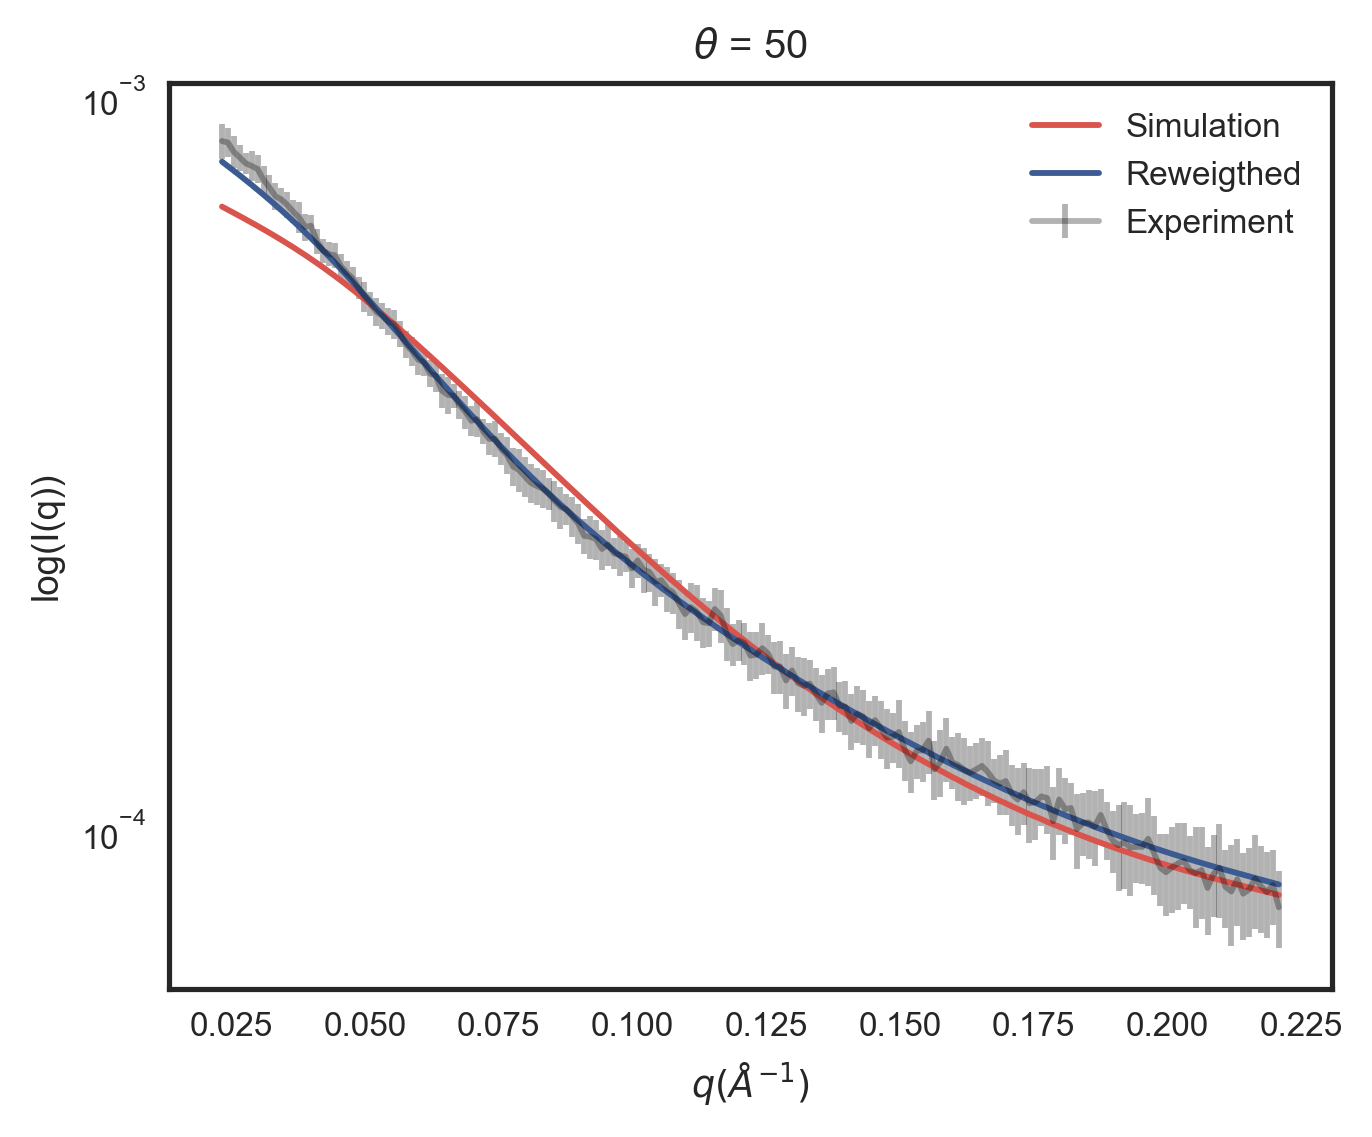

In [27]:

sts=genfromtxt("example2_0_.stats.dat");


fig, ax1 = plt.subplots(figsize=(5, 4))

plt.plot(sts[:,0],sts[:,3],label="Simulation",c=c2 )
plt.plot(sts[:,0],sts[:,4],label="Reweigthed" ,c=c3)
plt.title(r"$\theta$ = " + np.str(theta))
print (len(Rg))
plt.errorbar(sts[:,0],sts[:,1],yerr=sts[:,2],alpha=0.3,label="Experiment", c=c1)
plt.xlabel("$q (\AA^{-1})$")
#plt.ylabel("I")
plt.yscale('log')
plt.legend( prop={'size': 7.5})
plt.ylabel("log(I(q))",)
plt.legend()
plt.show()

